# NSDUH Drug Sequence Analysis Part 1a:  Dataset Exploration
## Matthew J. Beattie
## University of Oklahoma
__November 15, 2021__

This notebook conducts basic exploration of the druguse pathways dataset.

In [1]:
"""
Import python modules
"""
import pandas as pd

# Run parallel pandas on dask with Modin
#import modin.pandas as pd

import numpy as np
import copy
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools
import time as timelib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as math
import pathutils as pu
import json
import seaborn as sns

HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

FIGW = 12
FIGH = 5
FONTSIZE = 8
FIGURESIZE = (FIGW,FIGH)

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

random.seed(660806)


In [2]:
# Define working directories
datapath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Data3/'
workingpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Code3/'
outpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Output3/'
jsondict = datapath + 'NSDUH_field.json'

# Readin common variables
years = [2016, 2017, 2018, 2019]
stryear = '2016_2017_2018_2019'

ident, rawafuvals, afuvals, drugnames, drugorder, drugnums, drugposition, startdemog, demographics = pu.surveyvars(stryear)

# Allvars is the combination of all of the underlying variable sets
allvars = (ident + rawafuvals + startdemog)

# Readin dataset from prior step
loadfname = datapath + 'NSDUH_' + stryear + '_pathways.pkl'
nsduh2 = pd.read_pickle(loadfname)

# Decode dictionaries for NSDUH variables:
f1 = open(jsondict, 'r')
nsduhDecoder = json.load(f1)
f1.close()

In [3]:
nsduhDecoder

{'CATAG6': {'values': {'1': 'Youth',
   '2': '18-25',
   '3': '26-34',
   '4': '35-49',
   '5': '50-64',
   '6': '65+'}},
 'SVCFLAG': {'values': {'1': 'Military service', '0': 'No military service'}},
 'AGE2': {'values': {'1': '12',
   '2': '13',
   '3': '14',
   '4': '15',
   '5': '16',
   '6': '17',
   '7': '18',
   '8': '19',
   '9': '20',
   '10': '21',
   '11': '22 or 23',
   '12': '24 or 25',
   '13': '26 - 29',
   '14': '30 - 34',
   '15': '35 - 49',
   '16': '50 - 64',
   '17': '65+'}},
 'IRSEX': {'values': {'1': 'Male', '2': 'Female'}},
 'IRMARIT': {'values': {'1': 'Married',
   '2': 'Widowed',
   '3': 'Divorced/Sep',
   '4': 'Never Married',
   '99': 'Youth'}},
 'NEWRACE2': {'values': {'1': 'NonHisp White',
   '2': 'NonHisp Black',
   '3': 'NonHisp NatAmer',
   '4': 'NonHisp HI/PI',
   '5': 'NonHisp Asian',
   '6': 'NonHisp >1 Race',
   '7': 'Hispanic'}},
 'EDUHIGHCAT': {'values': {'1': '< High School',
   '2': 'HS Grad',
   '3': 'Some Coll',
   '4': 'Coll Grad',
   '5': 'You

In [4]:
# Convert fields in the demographic database to category variables.
catvars = copy.deepcopy(demographics)
catvars.remove('AGE2')
catvars.remove('RESPID')
catvars.remove('ANALWT_C')
alldemog = copy.deepcopy(catvars)
alldemog.append('YRWEIGHT')

# Create a new dataframe for translation of categorical values into
# reader friendly values from the NSDUH dictionary.
# Youth dictionary values are not considered.
tmpdf = copy.deepcopy(nsduh2[alldemog])
pipeprep = Pipeline([('makecats', pu.MakeCat(catvars))])
tmpdf = pipeprep.transform(tmpdf)

for fieldname in tmpdf.columns:
    newvallist = []
    if fieldname != 'RESPID' and fieldname != 'labels' and fieldname != 'YRWEIGHT':
        for key, value in nsduhDecoder[fieldname]['values'].items():
            if 'Youth' not in value:
                newvallist.append(value)
        tmpdf[fieldname].cat.categories = newvallist

In [5]:
tmpdf.head()

,SVCFLAG,CATAG6,IRSEX,IRMARIT,NEWRACE2,EDUHIGHCAT,IRWRKSTAT,GOVTPROG,INCOME,COUTYP4,AIIND102,YRWEIGHT
0,Military service,26-34,Female,Married,NonHisp White,Coll Grad,Other,No,>75k,Nonmetro,Not Amer Ind Area,204.858562
2,Military service,35-49,Male,Married,Hispanic,< High School,Unemployed,No,20k-49999,Large Metro,Not Amer Ind Area,2533.458396
3,Military service,65+,Female,Married,NonHisp White,Some Coll,Empl Part Time,No,50k-74999,Large Metro,Not Amer Ind Area,6203.973093
4,Military service,26-34,Male,Married,NonHisp Asian,Coll Grad,Other,No,20k-49999,Small Metro,Not Amer Ind Area,1386.672703
5,Military service,50-64,Male,Widowed,NonHisp White,HS Grad,Other,No,20k-49999,Small Metro,Not Amer Ind Area,2384.841656


In [8]:
tmpdf['YRWEIGHT'].sum()

247716947.4013222

Missingness in the data:  Series([], dtype: bool)


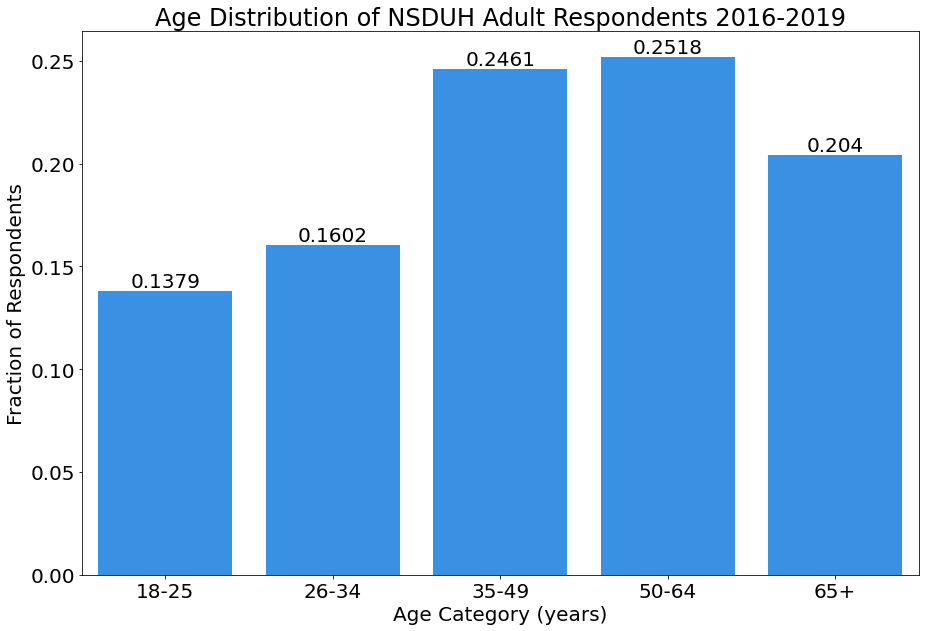

In [6]:
# Check for NA in any columns
print('Missingness in the data: ', tmpdf.isna().any()[lambda x: x])

# Calculate weighted age distribution
plotdf = tmpdf.groupby('CATAG6').sum('YRWEIGHT').sort_values(by='CATAG6', ascending=True)
totweight = plotdf['YRWEIGHT'].sum()
plotdf['fraction'] = round(plotdf['YRWEIGHT']/totweight,4)
plotdf.reset_index(inplace=True)

# Plot as a bar chart
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax1 = sns.barplot(x=plotdf['CATAG6'], y=plotdf['fraction'], color='dodgerblue')
ax1.bar_label(ax1.containers[0], fontsize=20)
ax1.set_xlabel('Age Category (years)', fontsize=20)
ax1.set_ylabel('Fraction of Respondents', fontsize=20)
ax1.set_title('Age Distribution of NSDUH Adult Respondents 2016-2019', fontsize=24)
plt.savefig(outpath + 'all_resp_age_dist.jpg')
plt.show()


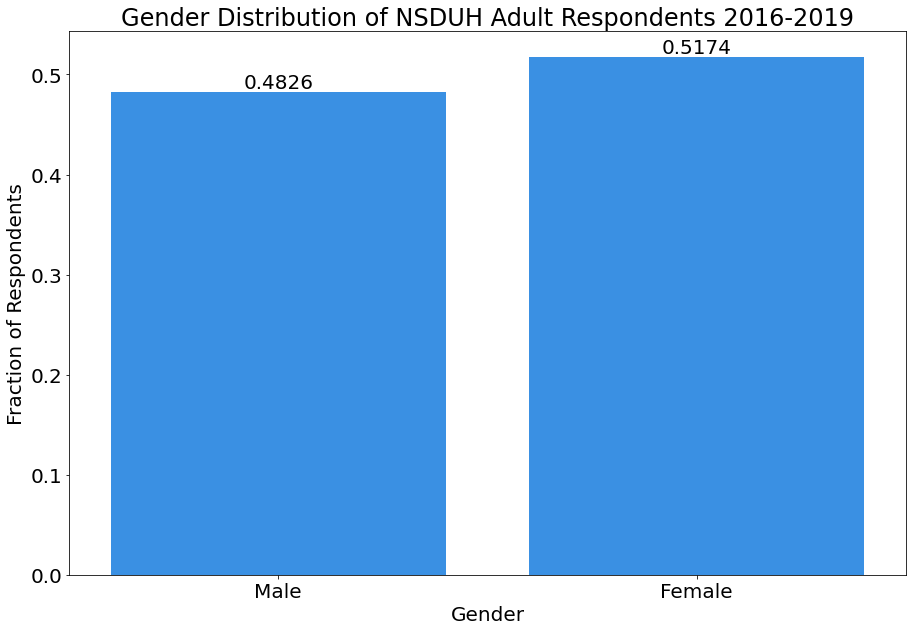

In [7]:
# Calculate weighted sex distribution
plotdf = tmpdf.groupby('IRSEX').sum('YRWEIGHT').sort_values(by='IRSEX', ascending=True)
totweight = plotdf['YRWEIGHT'].sum()
plotdf['fraction'] = round(plotdf['YRWEIGHT']/totweight,4)
plotdf.reset_index(inplace=True)

# Generate sex distribution plot
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax1 = sns.barplot(x=plotdf['IRSEX'], y=plotdf['fraction'], color='dodgerblue')
ax1.bar_label(ax1.containers[0], fontsize=20)
ax1.set_xlabel('Gender', fontsize=20)
ax1.set_ylabel('Fraction of Respondents', fontsize=20)
ax1.set_title('Gender Distribution of NSDUH Adult Respondents 2016-2019', fontsize=24)
plt.savefig(outpath + 'all_resp_gender_dist.jpg')
plt.show()


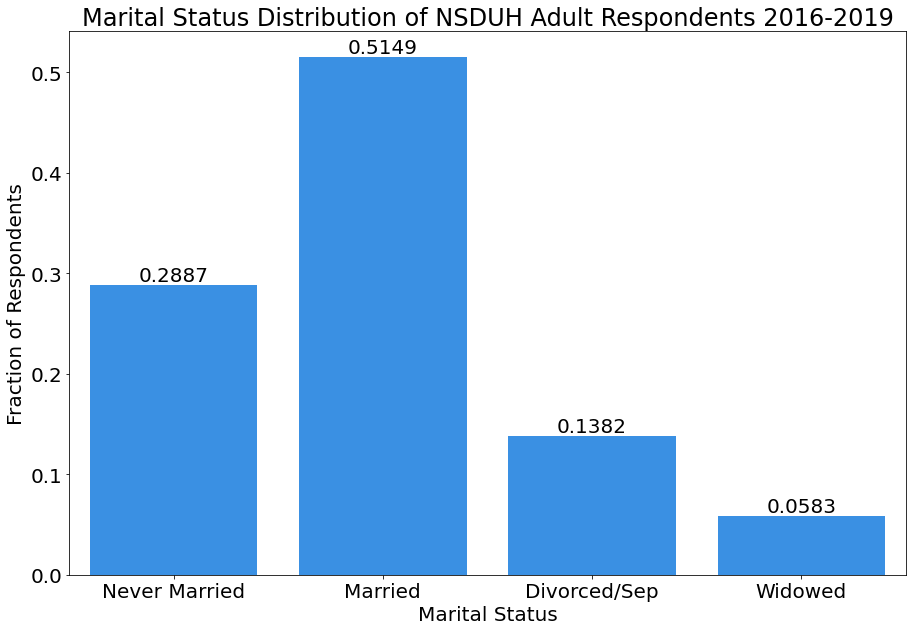

In [8]:
# Calculate weighted marriage distribution
plotdf = tmpdf.groupby('IRMARIT').sum('YRWEIGHT').sort_values(by='IRMARIT', ascending=True)
totweight = plotdf['YRWEIGHT'].sum()
plotdf['fraction'] = round(plotdf['YRWEIGHT']/totweight,4)
plotdf.reset_index(inplace=True)

# Generate marriage distribution plot
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
chart_order = ["Never Married", "Married", "Divorced/Sep", "Widowed"]
ax1 = sns.barplot(x=plotdf['IRMARIT'], y=plotdf['fraction'], color='dodgerblue', order=chart_order)
ax1.bar_label(ax1.containers[0], fontsize=20)
ax1.set_xlabel('Marital Status', fontsize=20)
ax1.set_ylabel('Fraction of Respondents', fontsize=20)
ax1.set_title('Marital Status Distribution of NSDUH Adult Respondents 2016-2019', fontsize=24)
plt.savefig(outpath + 'all_resp_marital_dist.jpg')
plt.show()


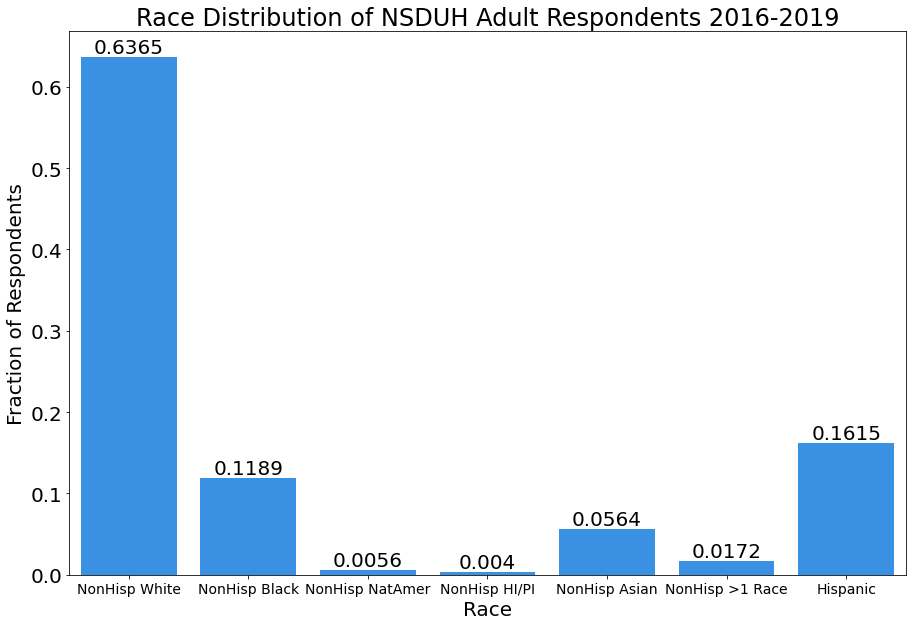

In [9]:
# Calculate weighted race distribution
plotdf = tmpdf.groupby('NEWRACE2').sum('YRWEIGHT').sort_values(by='NEWRACE2', ascending=True)
totweight = plotdf['YRWEIGHT'].sum()
plotdf['fraction'] = round(plotdf['YRWEIGHT']/totweight,4)
plotdf.reset_index(inplace=True)

# Generate race distribution plot
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
chart_order = ["NonHisp White", "NonHisp Black", "NonHisp NatAmer", "NonHisp HI/PI", "NonHisp Asian", "NonHisp >1 Race", "Hispanic"]
ax1 = sns.barplot(x=plotdf['NEWRACE2'], y=plotdf['fraction'], color='dodgerblue', order=chart_order)
ax1.bar_label(ax1.containers[0], fontsize=20)
ax1.set_xlabel('Race', fontsize=20)
ax1.set_ylabel('Fraction of Respondents', fontsize=20)
ax1.set_title('Race Distribution of NSDUH Adult Respondents 2016-2019', fontsize=24)
plt.savefig(outpath + 'all_resp_race_dist.jpg')
plt.show()


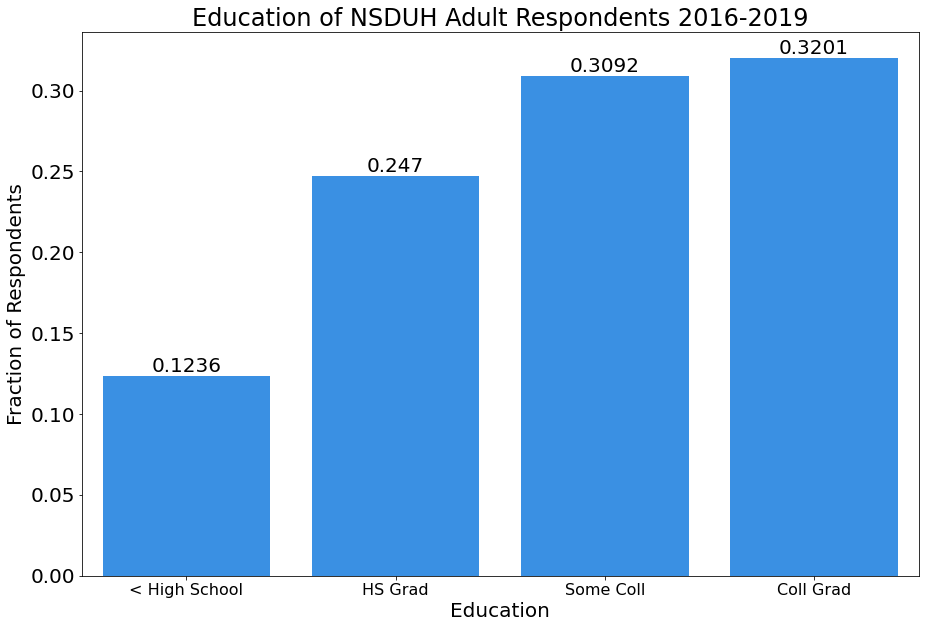

In [10]:
# Calculate weighted education distribution
plotdf = tmpdf.groupby('EDUHIGHCAT').sum('YRWEIGHT').sort_values(by='EDUHIGHCAT', ascending=True)
totweight = plotdf['YRWEIGHT'].sum()
plotdf['fraction'] = round(plotdf['YRWEIGHT']/totweight,4)
plotdf.reset_index(inplace=True)

# Generate education distribution plot
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
chart_order = ["< High School", "HS Grad", "Some Coll", "Coll Grad"]
ax1 = sns.barplot(x=plotdf['EDUHIGHCAT'], y=plotdf['fraction'], color='dodgerblue', order=chart_order)
ax1.bar_label(ax1.containers[0], fontsize=20)
ax1.set_xlabel('Education', fontsize=20)
ax1.set_ylabel('Fraction of Respondents', fontsize=20)
ax1.set_title('Education of NSDUH Adult Respondents 2016-2019', fontsize=24)
plt.savefig(outpath + 'all_resp_edu_dist.jpg')
plt.show()


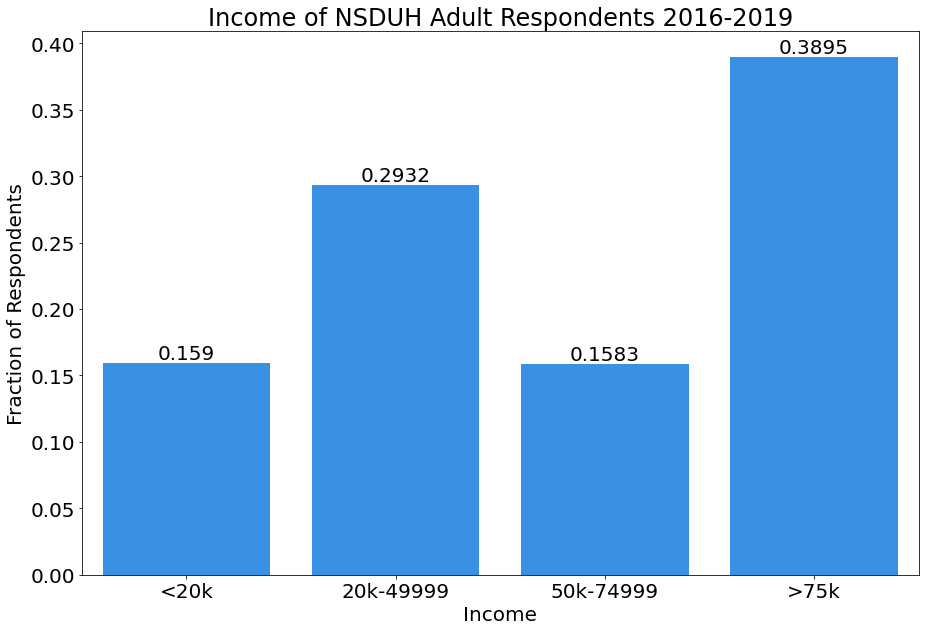

In [11]:
# Calculate income education distribution
plotdf = tmpdf.groupby('INCOME').sum('YRWEIGHT').sort_values(by='INCOME', ascending=True)
totweight = plotdf['YRWEIGHT'].sum()
plotdf['fraction'] = round(plotdf['YRWEIGHT']/totweight,4)
plotdf.reset_index(inplace=True)

# Generate income distribution plot
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
chart_order = ["<20k", "20k-49999", "50k-74999", ">75k"]
ax1 = sns.barplot(x=plotdf['INCOME'], y=plotdf['fraction'], color='dodgerblue', order=chart_order)
ax1.bar_label(ax1.containers[0], fontsize=20)
ax1.set_xlabel('Income', fontsize=20)
ax1.set_ylabel('Fraction of Respondents', fontsize=20)
ax1.set_title('Income of NSDUH Adult Respondents 2016-2019', fontsize=24)
plt.savefig(outpath + 'all_resp_income_dist.jpg')
plt.show()


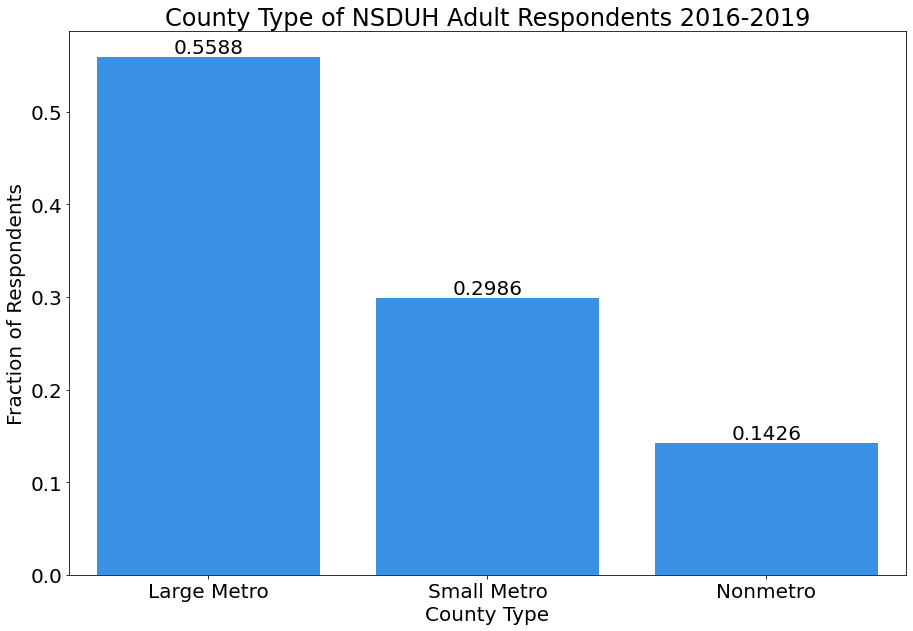

In [12]:
# Calculate county education distribution
plotdf = tmpdf.groupby('COUTYP4').sum('YRWEIGHT').sort_values(by='COUTYP4', ascending=True)
totweight = plotdf['YRWEIGHT'].sum()
plotdf['fraction'] = round(plotdf['YRWEIGHT']/totweight,4)
plotdf.reset_index(inplace=True)

# Generate county distribution plot
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
chart_order = ["Large Metro", "Small Metro", "Nonmetro"]
ax1 = sns.barplot(x=plotdf['COUTYP4'], y=plotdf['fraction'], color='dodgerblue', order=chart_order)
ax1.bar_label(ax1.containers[0], fontsize=20)
ax1.set_xlabel('County Type', fontsize=20)
ax1.set_ylabel('Fraction of Respondents', fontsize=20)
ax1.set_title('County Type of NSDUH Adult Respondents 2016-2019', fontsize=24)
plt.savefig(outpath + 'all_resp_county_dist.jpg')
plt.show()


### Generate simple drug use counts

In [13]:
# Generate drug use counts
totweight = nsduh2['YRWEIGHT'].sum()
print('Total of weights is:', totweight)

filename = outpath + 'simple_drugstats.txt'
fileout = open(filename, 'w')
print('DRUGAFU\tFRACTION\tAVGAFU', file=fileout)

def getcounts(df, druglist):
    for item in druglist:
        df['DRUGCOUNT'] = np.where(((df[item] > 0) & (df[item] < 991)), df['YRWEIGHT'], 0)
        df['DRUGYEARS'] = np.where(((df[item] > 0) & (df[item] < 991)), df[item]*df['YRWEIGHT'], 0)
        print(item, '\t', df['DRUGCOUNT'].sum()/totweight, '\t', df['DRUGYEARS'].sum()/df['DRUGCOUNT'].sum(), file=fileout)
        df.drop(['DRUGCOUNT'], axis='columns', inplace=True)
        df.drop(['DRUGYEARS'], axis='columns', inplace=True)
    return

druglist = ['IRTOBAGE', 'IRALCAGE', 'IRMJAGE', 'IRCOC2AGE', 'IRSCRIPAGE', 'IRHALLUCAGE',
            'IRINHALAGE', 'IRHERAGE', 'IRMETHAMAGE']

getcounts(nsduh2, druglist)
fileout.close()


Total of weights is: 247716947.4013222
